In [99]:
from stacked_hourglass import HumanPosePredictor, hg2, hg8, hg1
from stacked_hourglass.utils.transforms import shufflelr, crop, color_normalize, fliplr, transform
from PIL import Image
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import collections  as mc
import time, math,os
import PIL.ExifTags as ExifTags
from tqdm import tqdm
import seaborn as sns

In [129]:
# ...load image of a person into a PyTorch tensor...

model = hg2(pretrained=True)
predictor = HumanPosePredictor(model, device='cpu')
root = "/Users/seungyoun/Desktop/DGU/2/공개SW/pytorch-stacked-hourglass-master/dataset"

print("==model loaded==")

RGB_MEAN = torch.as_tensor([0.4404, 0.4440, 0.4327])
RGB_STDDEV = torch.as_tensor([0.2458, 0.2410, 0.2468])
#im = np.asarray(Image.open("./images/test14.jpeg"))
up = os.listdir(root + "/up")
down = os.listdir(root + "/down")
print("up   samples : ",len(up),"\ndown samples : ",len(down))

==model loaded==
up   samples :  110 
down samples :  82


In [130]:
from torchvision import transforms


def predict(path, resize):
    orgImg = Image.open(path)
    orgShape = orgImg.size
    orgImg = transforms.Resize((int(orgShape[0]*resize),int(orgShape[1]*resize)))(orgImg)
    print("image shape : ",orgImg.size)
    
    try:
        for orientation in ExifTags.TAGS.keys() :
            if ExifTags.TAGS[orientation]=='Orientation' : break
        exif=dict(orgImg._getexif().items())
        if exif[orientation] == 3:
            orgImg=orgImg.rotate(180, expand=True)
        elif exif[orientation] == 6 :
            orgImg=orgImg.rotate(270, expand=True)
        elif exif[orientation] == 8 :
            orgImg=orgImg.rotate(90, expand=True)

    except:
        pass
    im = np.asarray(orgImg)
    img = torch.tensor(im).transpose(0,2)
    img = color_normalize(img, RGB_MEAN, RGB_STDDEV)
    if(img.size(0)==4):
        img = img[:3]

    c,h,w = img.size()
    start = time.time()
    joints = predictor.estimate_joints(img, flip=True)
    end = time.time()
    xs,ys = list(joints[:,0].numpy()), list(joints[:,1].numpy())
    #print("infer time : ",end-start)


    left_antebrachial   = np.array([ys[15]-ys[14],xs[15]-xs[14]])
    left_forearm        = np.array([ys[13]-ys[14],xs[13]-xs[14]])
    left_back           = np.array([ys[7]-ys[13], xs[7]-xs[13]])
    left_arm_angle      = np.inner(left_antebrachial, left_forearm)/(np.linalg.norm(left_antebrachial)*np.linalg.norm(left_forearm))
    left_back_angle     = np.inner(left_forearm, left_back)/(np.linalg.norm(left_forearm)*np.linalg.norm(left_back))

    right_antebrachial  = np.array([ys[10]-ys[11],xs[10]-xs[11]])
    right_forearm       = np.array([ys[12]-ys[11],xs[12]-xs[11]])
    right_back          = np.array([ys[7]-ys[12], xs[7]-xs[12]])
    right_arm_angle     = np.inner(right_antebrachial, right_forearm)/(np.linalg.norm(right_antebrachial)*np.linalg.norm(right_forearm))
    right_back_angle    = np.inner(right_back, right_forearm)/(np.linalg.norm(right_back)*np.linalg.norm(right_forearm))

    left_arm_angle   = np.arccos(left_arm_angle)*360/(np.pi*2)
    left_back_angle  = 180-np.arccos(left_back_angle)*360/(np.pi*2)
    right_arm_angle  = np.arccos(right_arm_angle)*360/(np.pi*2)
    right_back_angle = 180-np.arccos(right_back_angle)*360/(np.pi*2)

    return left_arm_angle,left_back_angle,right_arm_angle,right_back_angle


In [131]:
upDist   = list()
downDist = list()

for i in tqdm(up):
    left_arm_angle,left_back_angle,right_arm_angle,right_back_angle = predict(root+"/up/"+i)
    upDist.append([left_arm_angle, left_back_angle, right_arm_angle, right_back_angle])

for i in tqdm(down):
    left_arm_angle,left_back_angle,right_arm_angle,right_back_angle = predict(root+"/down/"+i)
    downDist.append([left_arm_angle, left_back_angle, right_arm_angle, right_back_angle])










  0%|          | 0/110 [00:00<?, ?it/s]










TypeError: predict() missing 1 required positional argument: 'resize'

In [132]:
%matplotlib inline

## 올라간 동작 

In [133]:
left_arm_angle   = [theta[0] for theta in upDist]
left_back_angle  = [theta[1] for theta in upDist]
right_arm_angle  = [theta[2] for theta in upDist]
right_back_angle = [theta[3] for theta in upDist]

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6201: RuntimeWarning: invalid value encountered in true_divide
  m = (m.astype(float) / db) / m.sum()


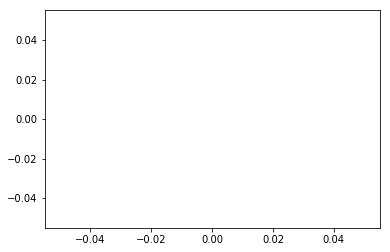

In [134]:
sns.distplot(left_arm_angle)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6201: RuntimeWarning: invalid value encountered in true_divide
  m = (m.astype(float) / db) / m.sum()


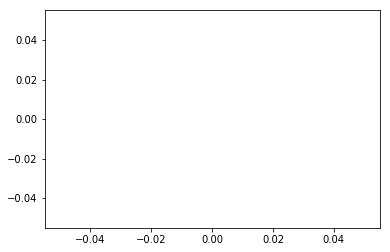

In [135]:
sns.distplot(left_back_angle)

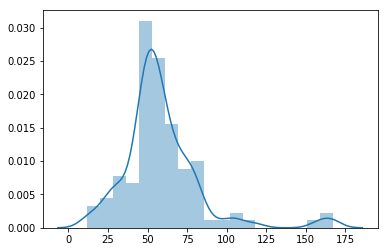

In [49]:
sns.distplot(right_arm_angle)

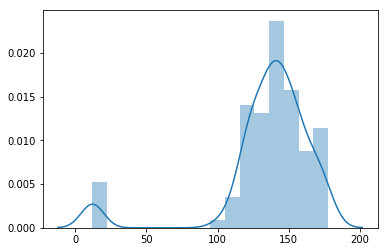

In [50]:
sns.distplot(right_back_angle)

## 내려간 동작

In [51]:
left_arm_angle0   = [theta[0] for theta in downDist]
left_back_angle0  = [theta[1] for theta in downDist]
right_arm_angle0  = [theta[2] for theta in downDist]
right_back_angle0 = [theta[3] for theta in downDist]

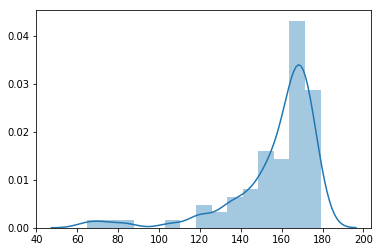

In [52]:
sns.distplot(left_arm_angle0)

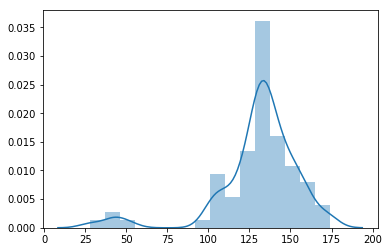

In [53]:
sns.distplot(left_back_angle0)

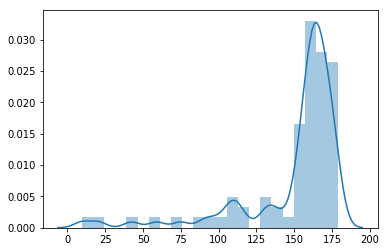

In [54]:
sns.distplot(right_arm_angle0)

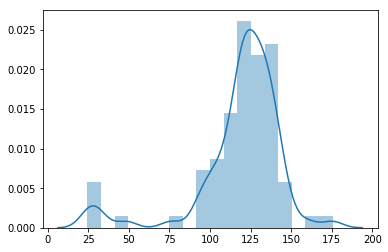

In [55]:
sns.distplot(right_back_angle0)

## 같이 비교해볼까요~?

In [56]:
kwargs = dict(alpha=0.5, bins=20)

왼쪽 팔 각

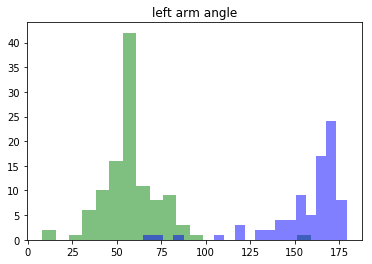

In [69]:
plt.hist(left_arm_angle , **kwargs, color='g', label='Ideal')
plt.hist(left_arm_angle0, **kwargs, color='b', label='Fair')
plt.gca().set(title='left arm angle')


오른쪽 팔 각

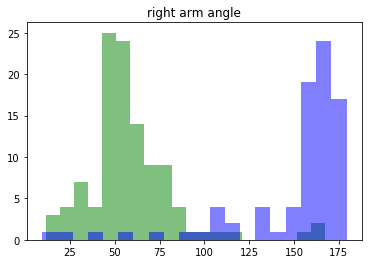

In [70]:
plt.hist(right_arm_angle , **kwargs, color='g', label='Ideal')
plt.hist(right_arm_angle0, **kwargs, color='b', label='Fair')
plt.gca().set(title='right arm angle')


왼쪽 광배 각

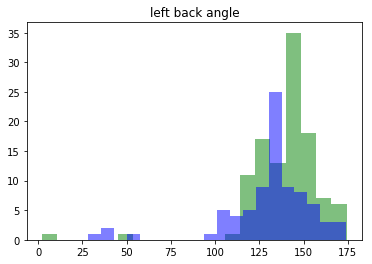

In [71]:
plt.hist(left_back_angle , **kwargs, color='g', label='Ideal')
plt.hist(left_back_angle0, **kwargs, color='b', label='Fair')
plt.gca().set(title='left back angle')


오른쪽 광배 각

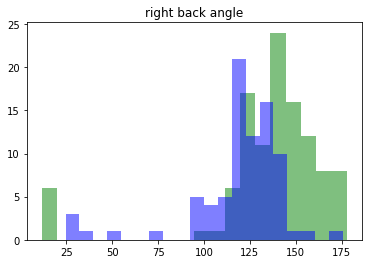

In [60]:
plt.hist(right_back_angle , **kwargs, color='g', label='Ideal')
plt.hist(right_back_angle0, **kwargs, color='b', label='Fair')
plt.gca().set(title='right back angle')


## Prediction Model

In [72]:
X = upDist+downDist
upCount   = len(upDist)
downCount = len(downDist)
Y = list()
for i in range(upCount):
    Y.append(1)
for i in range(downCount):
    Y.append(0)
X = np.asarray(X)
Y = np.asarray(Y)

In [136]:
import xgboost as xgb
from sklearn.metrics import accuracy_score


model = xgb.XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100,
                      silent=True, objective='binary:logistic',
                      booster='gbtree',
                      n_jobs=1, nthread=None, gamma=0, min_child_weight=1,
                      max_delta_step=0, subsample=1, colsample_bytree=1,
                      colsample_bylevel=1, reg_alpha=0, reg_lambda=1,
                      scale_pos_weight=1, base_score=0.5, random_state=0,
                      seed=None, missing=None)

In [74]:
model.fit(X,Y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [75]:
model.predict_proba(X[122].reshape(1,4))

array([[0.9924881 , 0.00751192]], dtype=float32)

In [76]:
model.save_model('xgboost.bst')

In [77]:
y_pred = model.predict(X)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(Y, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 99.48%


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


## Test image

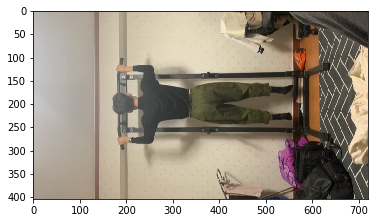

In [137]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle

#testImage = root+ '/updowntest/test3.jpg'
testImage = '/Users/seungyoun/Desktop/DGU/2/공개SW/pytorch-stacked-hourglass-master/video/pullup/67.jpg'
plt.imshow(mpimg.imread(testImage))

model.load_model('./xgboost.bst')  # load data


In [81]:
angles = predict(testImage)

In [82]:
pred = model.predict_proba(np.asarray(angles).reshape(1,4))
#pred_cls = model.predict(np.asarray(angles).reshape(1,4))

print(pred)

[[0.03251249 0.9674875 ]]


## 올라갔다 내려갔다~ (up and down probability change)

test1

In [142]:
testDir = '/Users/seungyoun/Desktop/DGU/2/공개SW/pytorch-stacked-hourglass-master/video/pullup3_1'
testInd = os.listdir(testDir)
testInd = sorted(testInd, key=lambda x: int(x.split(".")[0])) 
testImagesPaths = [testDir + "/" + i for i in testInd]

In [144]:
testResults=list()

start = time.time()
step = 0
sampling = 2
for i in tqdm(testImagesPaths):
    if(step%sampling == 0):
        theta = predict(i,resize=1)
        prob = model.predict_proba(np.asarray(theta).reshape(1,4))[0]
        testResults.append(prob[1])
    step+=1
end = time.time()
print(end-start)











  0%|          | 0/671 [00:00<?, ?it/s]

image shape :  (360, 640)












  0%|          | 1/671 [00:01<15:18,  1.37s/it]

image shape :  (360, 640)












  1%|          | 4/671 [00:02<12:12,  1.10s/it]

image shape :  (360, 640)












  1%|          | 7/671 [00:04<10:06,  1.09it/s]

image shape :  (360, 640)












  1%|▏         | 10/671 [00:05<08:35,  1.28it/s]

image shape :  (360, 640)












  2%|▏         | 13/671 [00:06<07:30,  1.46it/s]

image shape :  (360, 640)












  2%|▏         | 16/671 [00:08<06:44,  1.62it/s]

image shape :  (360, 640)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in float_scalars










  3%|▎         | 19/671 [00:09<06:14,  1.74it/s]

image shape :  (360, 640)












  3%|▎         | 22/671 [00:11<06:00,  1.80it/s]

image shape :  (360, 640)












  4%|▎         | 25/671 [00:12<05:47,  1.86it/s]

image shape :  (360, 640)












  4%|▍         | 28/671 [00:14<05:30,  1.94it/s]

image shape :  (360, 640)












  5%|▍         | 31/671 [00:15<05:27,  1.95it/s]

image shape :  (360, 640)












  5%|▌         | 34/671 [00:17<05:53,  1.80it/s]

image shape :  (360, 640)












  6%|▌         | 37/671 [00:19<05:30,  1.92it/s]

image shape :  (360, 640)












  6%|▌         | 40/671 [00:20<05:19,  1.98it/s]

image shape :  (360, 640)












  6%|▋         | 43/671 [00:22<05:44,  1.82it/s]

image shape :  (360, 640)












  7%|▋         | 46/671 [00:24<06:12,  1.68it/s]

image shape :  (360, 640)












  7%|▋         | 49/671 [00:26<05:59,  1.73it/s]

image shape :  (360, 640)












  8%|▊         | 52/671 [00:27<05:48,  1.78it/s]

image shape :  (360, 640)












  8%|▊         | 55/671 [00:29<05:35,  1.83it/s]

image shape :  (360, 640)












  9%|▊         | 58/671 [00:30<05:25,  1.88it/s]

image shape :  (360, 640)












  9%|▉         | 61/671 [00:31<05:06,  1.99it/s]

image shape :  (360, 640)












 10%|▉         | 64/671 [00:33<04:49,  2.10it/s]

image shape :  (360, 640)












 10%|▉         | 67/671 [00:34<04:42,  2.14it/s]

image shape :  (360, 640)












 10%|█         | 70/671 [00:35<04:37,  2.16it/s]

image shape :  (360, 640)












 11%|█         | 73/671 [00:37<04:30,  2.21it/s]

image shape :  (360, 640)












 11%|█▏        | 76/671 [00:38<04:27,  2.23it/s]

image shape :  (360, 640)












 12%|█▏        | 79/671 [00:39<04:31,  2.18it/s]

image shape :  (360, 640)












 12%|█▏        | 82/671 [00:41<04:40,  2.10it/s]

image shape :  (360, 640)












 13%|█▎        | 85/671 [00:42<04:38,  2.10it/s]

image shape :  (360, 640)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in float_scalars










 13%|█▎        | 88/671 [00:44<04:32,  2.14it/s]

image shape :  (360, 640)












 14%|█▎        | 91/671 [00:45<04:22,  2.21it/s]

image shape :  (360, 640)












 14%|█▍        | 94/671 [00:47<04:29,  2.14it/s]

image shape :  (360, 640)












 14%|█▍        | 97/671 [00:48<04:39,  2.05it/s]

image shape :  (360, 640)












 15%|█▍        | 100/671 [00:50<04:43,  2.01it/s]

image shape :  (360, 640)












 15%|█▌        | 103/671 [00:51<04:40,  2.02it/s]

image shape :  (360, 640)












 16%|█▌        | 106/671 [00:53<04:37,  2.03it/s]

image shape :  (360, 640)












 16%|█▌        | 109/671 [00:54<04:43,  1.98it/s]

image shape :  (360, 640)












 17%|█▋        | 112/671 [00:56<04:45,  1.96it/s]

image shape :  (360, 640)












 17%|█▋        | 115/671 [00:57<04:39,  1.99it/s]

image shape :  (360, 640)












 18%|█▊        | 118/671 [00:59<04:28,  2.06it/s]

image shape :  (360, 640)












 18%|█▊        | 121/671 [01:00<04:15,  2.15it/s]

image shape :  (360, 640)












 18%|█▊        | 124/671 [01:01<04:05,  2.23it/s]

image shape :  (360, 640)












 19%|█▉        | 127/671 [01:02<03:58,  2.28it/s]

image shape :  (360, 640)












 19%|█▉        | 130/671 [01:04<03:54,  2.31it/s]

image shape :  (360, 640)












 20%|█▉        | 133/671 [01:05<03:50,  2.33it/s]

image shape :  (360, 640)












 20%|██        | 136/671 [01:06<04:03,  2.19it/s]

image shape :  (360, 640)












 21%|██        | 139/671 [01:08<04:02,  2.20it/s]

image shape :  (360, 640)












 21%|██        | 142/671 [01:09<03:59,  2.20it/s]

image shape :  (360, 640)












 22%|██▏       | 145/671 [01:10<03:56,  2.23it/s]

image shape :  (360, 640)












 22%|██▏       | 148/671 [01:12<03:48,  2.29it/s]

image shape :  (360, 640)












 23%|██▎       | 151/671 [01:13<03:45,  2.31it/s]

image shape :  (360, 640)












 23%|██▎       | 154/671 [01:14<03:47,  2.27it/s]

image shape :  (360, 640)












 23%|██▎       | 157/671 [01:16<03:47,  2.26it/s]

image shape :  (360, 640)












 24%|██▍       | 160/671 [01:17<03:54,  2.18it/s]

image shape :  (360, 640)












 24%|██▍       | 163/671 [01:19<03:52,  2.18it/s]

image shape :  (360, 640)












 25%|██▍       | 166/671 [01:20<03:44,  2.25it/s]

image shape :  (360, 640)












 25%|██▌       | 169/671 [01:21<03:38,  2.30it/s]

image shape :  (360, 640)












 26%|██▌       | 172/671 [01:22<03:36,  2.30it/s]

image shape :  (360, 640)












 26%|██▌       | 175/671 [01:24<03:41,  2.23it/s]

image shape :  (360, 640)












 27%|██▋       | 178/671 [01:25<03:46,  2.18it/s]

image shape :  (360, 640)












 27%|██▋       | 181/671 [01:27<03:45,  2.18it/s]

image shape :  (360, 640)












 27%|██▋       | 184/671 [01:28<03:40,  2.21it/s]

image shape :  (360, 640)












 28%|██▊       | 187/671 [01:29<03:32,  2.27it/s]

image shape :  (360, 640)












 28%|██▊       | 190/671 [01:30<03:27,  2.32it/s]

image shape :  (360, 640)












 29%|██▉       | 193/671 [01:32<03:27,  2.30it/s]

image shape :  (360, 640)












 29%|██▉       | 196/671 [01:33<03:29,  2.26it/s]

image shape :  (360, 640)












 30%|██▉       | 199/671 [01:34<03:24,  2.31it/s]

image shape :  (360, 640)












 30%|███       | 202/671 [01:36<03:21,  2.33it/s]

image shape :  (360, 640)












 31%|███       | 205/671 [01:37<03:18,  2.34it/s]

image shape :  (360, 640)












 31%|███       | 208/671 [01:38<03:15,  2.37it/s]

image shape :  (360, 640)












 31%|███▏      | 211/671 [01:39<03:16,  2.34it/s]

image shape :  (360, 640)












 32%|███▏      | 214/671 [01:41<03:17,  2.32it/s]

image shape :  (360, 640)












 32%|███▏      | 217/671 [01:42<03:14,  2.34it/s]

image shape :  (360, 640)












 33%|███▎      | 220/671 [01:43<03:11,  2.36it/s]

image shape :  (360, 640)












 33%|███▎      | 223/671 [01:45<03:13,  2.32it/s]

image shape :  (360, 640)












 34%|███▎      | 226/671 [01:46<03:23,  2.19it/s]

image shape :  (360, 640)












 34%|███▍      | 229/671 [01:48<03:31,  2.09it/s]

image shape :  (360, 640)












 35%|███▍      | 232/671 [01:49<03:32,  2.07it/s]

image shape :  (360, 640)












 35%|███▌      | 235/671 [01:51<03:32,  2.05it/s]

image shape :  (360, 640)












 35%|███▌      | 238/671 [01:52<03:34,  2.02it/s]

image shape :  (360, 640)












 36%|███▌      | 241/671 [01:53<03:25,  2.09it/s]

image shape :  (360, 640)












 36%|███▋      | 244/671 [01:55<03:15,  2.18it/s]

image shape :  (360, 640)












 37%|███▋      | 247/671 [01:56<03:13,  2.19it/s]

image shape :  (360, 640)












 37%|███▋      | 250/671 [01:57<03:11,  2.19it/s]

image shape :  (360, 640)












 38%|███▊      | 253/671 [01:59<03:04,  2.26it/s]

image shape :  (360, 640)












 38%|███▊      | 256/671 [02:00<02:59,  2.31it/s]

image shape :  (360, 640)












 39%|███▊      | 259/671 [02:01<03:01,  2.27it/s]

image shape :  (360, 640)












 39%|███▉      | 262/671 [02:03<02:59,  2.27it/s]

image shape :  (360, 640)












 39%|███▉      | 265/671 [02:04<02:54,  2.32it/s]

image shape :  (360, 640)












 40%|███▉      | 268/671 [02:05<02:50,  2.36it/s]

image shape :  (360, 640)












 40%|████      | 271/671 [02:06<02:49,  2.36it/s]

image shape :  (360, 640)












 41%|████      | 274/671 [02:08<02:47,  2.38it/s]

image shape :  (360, 640)












 41%|████▏     | 277/671 [02:09<02:46,  2.36it/s]

image shape :  (360, 640)












 42%|████▏     | 280/671 [02:10<02:44,  2.38it/s]

image shape :  (360, 640)












 42%|████▏     | 283/671 [02:11<02:41,  2.40it/s]

image shape :  (360, 640)












 43%|████▎     | 286/671 [02:13<02:40,  2.40it/s]

image shape :  (360, 640)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in arccos










 43%|████▎     | 289/671 [02:14<02:39,  2.40it/s]

image shape :  (360, 640)












 44%|████▎     | 292/671 [02:15<02:37,  2.41it/s]

image shape :  (360, 640)












 44%|████▍     | 295/671 [02:16<02:37,  2.38it/s]

image shape :  (360, 640)












 44%|████▍     | 298/671 [02:18<02:36,  2.39it/s]

image shape :  (360, 640)












 45%|████▍     | 301/671 [02:19<02:33,  2.40it/s]

image shape :  (360, 640)












 45%|████▌     | 304/671 [02:20<02:33,  2.40it/s]

image shape :  (360, 640)












 46%|████▌     | 307/671 [02:21<02:30,  2.42it/s]

image shape :  (360, 640)












 46%|████▌     | 310/671 [02:23<02:29,  2.41it/s]

image shape :  (360, 640)












 47%|████▋     | 313/671 [02:24<02:28,  2.41it/s]

image shape :  (360, 640)












 47%|████▋     | 316/671 [02:25<02:26,  2.42it/s]

image shape :  (360, 640)












 48%|████▊     | 319/671 [02:26<02:26,  2.41it/s]

image shape :  (360, 640)












 48%|████▊     | 322/671 [02:28<02:24,  2.41it/s]

image shape :  (360, 640)












 48%|████▊     | 325/671 [02:29<02:23,  2.41it/s]

image shape :  (360, 640)












 49%|████▉     | 328/671 [02:30<02:21,  2.42it/s]

image shape :  (360, 640)












 49%|████▉     | 331/671 [02:31<02:20,  2.42it/s]

image shape :  (360, 640)












 50%|████▉     | 334/671 [02:32<02:19,  2.42it/s]

image shape :  (360, 640)












 50%|█████     | 337/671 [02:34<02:18,  2.42it/s]

image shape :  (360, 640)












 51%|█████     | 340/671 [02:35<02:16,  2.42it/s]

image shape :  (360, 640)












 51%|█████     | 343/671 [02:36<02:15,  2.42it/s]

image shape :  (360, 640)












 52%|█████▏    | 346/671 [02:38<02:27,  2.21it/s]

image shape :  (360, 640)












 52%|█████▏    | 349/671 [02:39<02:27,  2.18it/s]

image shape :  (360, 640)












 52%|█████▏    | 352/671 [02:41<02:26,  2.17it/s]

image shape :  (360, 640)












 53%|█████▎    | 355/671 [02:42<02:23,  2.20it/s]

image shape :  (360, 640)












 53%|█████▎    | 358/671 [02:43<02:18,  2.26it/s]

image shape :  (360, 640)












 54%|█████▍    | 361/671 [02:44<02:14,  2.31it/s]

image shape :  (360, 640)












 54%|█████▍    | 364/671 [02:46<02:10,  2.35it/s]

image shape :  (360, 640)












 55%|█████▍    | 367/671 [02:47<02:08,  2.37it/s]

image shape :  (360, 640)












 55%|█████▌    | 370/671 [02:48<02:07,  2.36it/s]

image shape :  (360, 640)












 56%|█████▌    | 373/671 [02:50<02:10,  2.29it/s]

image shape :  (360, 640)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in arccos










 56%|█████▌    | 376/671 [02:51<02:10,  2.26it/s]

image shape :  (360, 640)












 56%|█████▋    | 379/671 [02:52<02:13,  2.19it/s]

image shape :  (360, 640)












 57%|█████▋    | 382/671 [02:54<02:10,  2.22it/s]

image shape :  (360, 640)












 57%|█████▋    | 385/671 [02:55<02:08,  2.22it/s]

image shape :  (360, 640)












 58%|█████▊    | 388/671 [02:56<02:07,  2.22it/s]

image shape :  (360, 640)












 58%|█████▊    | 391/671 [02:58<02:03,  2.27it/s]

image shape :  (360, 640)












 59%|█████▊    | 394/671 [02:59<02:00,  2.30it/s]

image shape :  (360, 640)












 59%|█████▉    | 397/671 [03:00<01:57,  2.34it/s]

image shape :  (360, 640)












 60%|█████▉    | 400/671 [03:02<01:58,  2.29it/s]

image shape :  (360, 640)












 60%|██████    | 403/671 [03:03<01:59,  2.25it/s]

image shape :  (360, 640)












 61%|██████    | 406/671 [03:04<01:58,  2.24it/s]

image shape :  (360, 640)












 61%|██████    | 409/671 [03:06<01:54,  2.29it/s]

image shape :  (360, 640)












 61%|██████▏   | 412/671 [03:07<01:51,  2.32it/s]

image shape :  (360, 640)












 62%|██████▏   | 415/671 [03:08<01:54,  2.24it/s]

image shape :  (360, 640)












 62%|██████▏   | 418/671 [03:10<01:55,  2.19it/s]

image shape :  (360, 640)












 63%|██████▎   | 421/671 [03:11<01:52,  2.22it/s]

image shape :  (360, 640)












 63%|██████▎   | 424/671 [03:12<01:48,  2.27it/s]

image shape :  (360, 640)












 64%|██████▎   | 427/671 [03:13<01:45,  2.32it/s]

image shape :  (360, 640)












 64%|██████▍   | 430/671 [03:15<01:45,  2.29it/s]

image shape :  (360, 640)












 65%|██████▍   | 433/671 [03:16<01:43,  2.30it/s]

image shape :  (360, 640)












 65%|██████▍   | 436/671 [03:17<01:40,  2.33it/s]

image shape :  (360, 640)












 65%|██████▌   | 439/671 [03:19<01:39,  2.34it/s]

image shape :  (360, 640)












 66%|██████▌   | 442/671 [03:20<01:38,  2.33it/s]

image shape :  (360, 640)












 66%|██████▋   | 445/671 [03:21<01:37,  2.32it/s]

image shape :  (360, 640)












 67%|██████▋   | 448/671 [03:23<01:35,  2.32it/s]

image shape :  (360, 640)












 67%|██████▋   | 451/671 [03:24<01:35,  2.31it/s]

image shape :  (360, 640)












 68%|██████▊   | 454/671 [03:25<01:32,  2.35it/s]

image shape :  (360, 640)












 68%|██████▊   | 457/671 [03:26<01:32,  2.32it/s]

image shape :  (360, 640)












 69%|██████▊   | 460/671 [03:28<01:34,  2.24it/s]

image shape :  (360, 640)












 69%|██████▉   | 463/671 [03:29<01:34,  2.19it/s]

image shape :  (360, 640)












 69%|██████▉   | 466/671 [03:31<01:34,  2.18it/s]

image shape :  (360, 640)












 70%|██████▉   | 469/671 [03:32<01:33,  2.15it/s]

image shape :  (360, 640)












 70%|███████   | 472/671 [03:33<01:30,  2.20it/s]

image shape :  (360, 640)












 71%|███████   | 475/671 [03:35<01:31,  2.13it/s]

image shape :  (360, 640)












 71%|███████   | 478/671 [03:36<01:29,  2.15it/s]

image shape :  (360, 640)












 72%|███████▏  | 481/671 [03:38<01:26,  2.19it/s]

image shape :  (360, 640)












 72%|███████▏  | 484/671 [03:39<01:26,  2.16it/s]

image shape :  (360, 640)












 73%|███████▎  | 487/671 [03:40<01:26,  2.13it/s]

image shape :  (360, 640)












 73%|███████▎  | 490/671 [03:42<01:28,  2.05it/s]

image shape :  (360, 640)












 73%|███████▎  | 493/671 [03:44<01:26,  2.05it/s]

image shape :  (360, 640)












 74%|███████▍  | 496/671 [03:45<01:24,  2.08it/s]

image shape :  (360, 640)












 74%|███████▍  | 499/671 [03:46<01:20,  2.14it/s]

image shape :  (360, 640)












 75%|███████▍  | 502/671 [03:47<01:16,  2.21it/s]

image shape :  (360, 640)












 75%|███████▌  | 505/671 [03:49<01:13,  2.27it/s]

image shape :  (360, 640)












 76%|███████▌  | 508/671 [03:50<01:10,  2.31it/s]

image shape :  (360, 640)












 76%|███████▌  | 511/671 [03:51<01:08,  2.33it/s]

image shape :  (360, 640)












 77%|███████▋  | 514/671 [03:53<01:11,  2.19it/s]

image shape :  (360, 640)












 77%|███████▋  | 517/671 [03:54<01:10,  2.19it/s]

image shape :  (360, 640)












 77%|███████▋  | 520/671 [03:55<01:06,  2.26it/s]

image shape :  (360, 640)












 78%|███████▊  | 523/671 [03:57<01:04,  2.31it/s]

image shape :  (360, 640)












 78%|███████▊  | 526/671 [03:58<01:02,  2.34it/s]

image shape :  (360, 640)












 79%|███████▉  | 529/671 [03:59<00:59,  2.37it/s]

image shape :  (360, 640)












 79%|███████▉  | 532/671 [04:00<00:58,  2.39it/s]

image shape :  (360, 640)












 80%|███████▉  | 535/671 [04:02<00:59,  2.29it/s]

image shape :  (360, 640)












 80%|████████  | 538/671 [04:03<00:59,  2.23it/s]

image shape :  (360, 640)












 81%|████████  | 541/671 [04:05<00:58,  2.23it/s]

image shape :  (360, 640)












 81%|████████  | 544/671 [04:06<00:57,  2.20it/s]

image shape :  (360, 640)












 82%|████████▏ | 547/671 [04:07<00:56,  2.20it/s]

image shape :  (360, 640)












 82%|████████▏ | 550/671 [04:09<00:54,  2.24it/s]

image shape :  (360, 640)












 82%|████████▏ | 553/671 [04:10<00:51,  2.29it/s]

image shape :  (360, 640)












 83%|████████▎ | 556/671 [04:11<00:49,  2.33it/s]

image shape :  (360, 640)












 83%|████████▎ | 559/671 [04:12<00:48,  2.29it/s]

image shape :  (360, 640)












 84%|████████▍ | 562/671 [04:14<00:48,  2.27it/s]

image shape :  (360, 640)












 84%|████████▍ | 565/671 [04:15<00:45,  2.31it/s]

image shape :  (360, 640)












 85%|████████▍ | 568/671 [04:16<00:43,  2.35it/s]

image shape :  (360, 640)












 85%|████████▌ | 571/671 [04:18<00:43,  2.32it/s]

image shape :  (360, 640)












 86%|████████▌ | 574/671 [04:19<00:42,  2.26it/s]

image shape :  (360, 640)












 86%|████████▌ | 577/671 [04:20<00:41,  2.25it/s]

image shape :  (360, 640)












 86%|████████▋ | 580/671 [04:22<00:41,  2.21it/s]

image shape :  (360, 640)












 87%|████████▋ | 583/671 [04:23<00:40,  2.17it/s]

image shape :  (360, 640)












 87%|████████▋ | 586/671 [04:25<00:39,  2.17it/s]

image shape :  (360, 640)












 88%|████████▊ | 589/671 [04:26<00:36,  2.24it/s]

image shape :  (360, 640)












 88%|████████▊ | 592/671 [04:27<00:35,  2.23it/s]

image shape :  (360, 640)












 89%|████████▊ | 595/671 [04:29<00:34,  2.23it/s]

image shape :  (360, 640)












 89%|████████▉ | 598/671 [04:30<00:31,  2.28it/s]

image shape :  (360, 640)












 90%|████████▉ | 601/671 [04:31<00:30,  2.33it/s]

image shape :  (360, 640)












 90%|█████████ | 604/671 [04:32<00:28,  2.35it/s]

image shape :  (360, 640)












 90%|█████████ | 607/671 [04:33<00:27,  2.36it/s]

image shape :  (360, 640)












 91%|█████████ | 610/671 [04:35<00:25,  2.37it/s]

image shape :  (360, 640)












 91%|█████████▏| 613/671 [04:36<00:24,  2.35it/s]

image shape :  (360, 640)












 92%|█████████▏| 616/671 [04:37<00:24,  2.28it/s]

image shape :  (360, 640)












 92%|█████████▏| 619/671 [04:39<00:22,  2.32it/s]

image shape :  (360, 640)












 93%|█████████▎| 622/671 [04:40<00:20,  2.36it/s]

image shape :  (360, 640)












 93%|█████████▎| 625/671 [04:41<00:19,  2.38it/s]

image shape :  (360, 640)












 94%|█████████▎| 628/671 [04:43<00:18,  2.31it/s]

image shape :  (360, 640)












 94%|█████████▍| 631/671 [04:44<00:17,  2.25it/s]

image shape :  (360, 640)












 94%|█████████▍| 634/671 [04:45<00:16,  2.23it/s]

image shape :  (360, 640)












 95%|█████████▍| 637/671 [04:47<00:14,  2.28it/s]

image shape :  (360, 640)












 95%|█████████▌| 640/671 [04:48<00:13,  2.32it/s]

image shape :  (360, 640)












 96%|█████████▌| 643/671 [04:49<00:12,  2.28it/s]

image shape :  (360, 640)












 96%|█████████▋| 646/671 [04:51<00:11,  2.25it/s]

image shape :  (360, 640)












 97%|█████████▋| 649/671 [04:52<00:09,  2.21it/s]

image shape :  (360, 640)












 97%|█████████▋| 652/671 [04:53<00:08,  2.23it/s]

image shape :  (360, 640)












 98%|█████████▊| 655/671 [04:55<00:07,  2.24it/s]

image shape :  (360, 640)












 98%|█████████▊| 658/671 [04:56<00:05,  2.20it/s]

image shape :  (360, 640)












 99%|█████████▊| 661/671 [04:58<00:04,  2.15it/s]

image shape :  (360, 640)












 99%|█████████▉| 664/671 [04:59<00:03,  2.12it/s]

image shape :  (360, 640)












 99%|█████████▉| 667/671 [05:00<00:01,  2.10it/s]

image shape :  (360, 640)












100%|█████████▉| 670/671 [05:02<00:00,  2.11it/s]









100%|██████████| 671/671 [05:02<00:00,  2.22it/s]

302.35191893577576


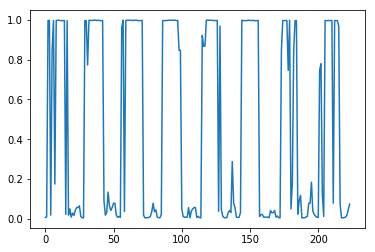

In [145]:
sample = 700

pl = testResults[:sample]
sns.lineplot(x = [i for i in range(len(pl))], y= pl)

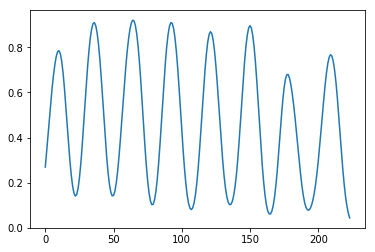

In [172]:
from astropy.convolution import Gaussian1DKernel, convolve

#conv kernel
g = Gaussian1DKernel(stddev=4)

# Convolve data
z = convolve(testResults[:sample], g)

#plot smoothed data
sns.lineplot(x = [i for i in range(len(z))], y= z)

test2

In [40]:
testDir2 = '/Users/seungyoun/Desktop/DGU/2/공개SW/pytorch-stacked-hourglass-master/video/pullup2'
testInd2 = os.listdir(testDir2)
testInd2 = sorted(testInd2, key=lambda x: int(x.split(".")[0])) 
testImagesPaths2 = [testDir2 + "/" + i for i in testInd2]

In [ ]:
testResults2=list()
for i in tqdm(testImagesPaths2):
    theta = predict(i)
    prob = model.predict_proba(np.asarray(theta).reshape(1,4))[0]
    testResults2.append(prob[1])

In [ ]:
sns.lineplot(x = [i for i in range(len(testResults2))], y= testResults2)

In [28]:
def decide(past, now):
    if(past is None):
        return -1
    else:
        if((past<=0.35) and (now>0.9) ):
            #up
            return 1
        elif((past>0.9) and (now<=0.35)):
            #down
            return 0
        else:
            return -1

In [118]:
for i in range(len(testResults)-1):
    if(decide(testResults[i], testResults[i+1]) != -1):
        print(decide(testResults[i], testResults[i+1]))

1
0


## video2count

In [38]:
import cv2

path      = '/Users/seungyoun/Desktop/DGU/2/공개SW/pytorch-stacked-hourglass-master/video/pullup2.mp4'
save_path = '/Users/seungyoun/Desktop/DGU/2/공개SW/pytorch-stacked-hourglass-master/results'

In [39]:
from PIL import ImageFont
from PIL import ImageDraw 

cap = cv2.VideoCapture(path)

RGB_MEAN = torch.as_tensor([0.4404, 0.4440, 0.4327])
RGB_STDDEV = torch.as_tensor([0.2458, 0.2410, 0.2468])

idx = 1
count = 0
past = None

while(cap.isOpened()):
    ret, frame = cap.read()
    img = torch.tensor(frame).transpose(0,2)
    img = color_normalize(img, RGB_MEAN, RGB_STDDEV)

    PILImage = Image.fromarray(frame, 'RGB')
    draw = ImageDraw.Draw(PILImage)
    #font_type = ImageFont.truetype("arial.ttf", 18)
    
    if(img.size(0)==4):
        img = img[:3]

    c,h,w = img.size()
    start = time.time()
    joints = predictor.estimate_joints(img, flip=True)
    end = time.time()
    xs,ys = list(joints[:,0].numpy()), list(joints[:,1].numpy())
    #print("infer time : ",end-start)


    left_antebrachial   = np.array([ys[15]-ys[14],xs[15]-xs[14]])
    left_forearm        = np.array([ys[13]-ys[14],xs[13]-xs[14]])
    left_back           = np.array([ys[7]-ys[13], xs[7]-xs[13]])
    left_arm_angle      = np.inner(left_antebrachial, left_forearm)/(np.linalg.norm(left_antebrachial)*np.linalg.norm(left_forearm))
    left_back_angle     = np.inner(left_forearm, left_back)/(np.linalg.norm(left_forearm)*np.linalg.norm(left_back))

    right_antebrachial  = np.array([ys[10]-ys[11],xs[10]-xs[11]])
    right_forearm       = np.array([ys[12]-ys[10],xs[12]-xs[10]])
    right_back          = np.array([ys[7]-ys[12], xs[7]-xs[12]])
    right_arm_angle     = np.inner(right_antebrachial, right_forearm)/(np.linalg.norm(right_antebrachial)*np.linalg.norm(right_forearm))
    right_back_angle    = np.inner(right_back, right_forearm)/(np.linalg.norm(right_back)*np.linalg.norm(right_forearm))

    left_arm_angle   = np.arccos(left_arm_angle)*360/(np.pi*2)
    left_back_angle  = 180-np.arccos(left_back_angle)*360/(np.pi*2)
    right_arm_angle  = np.arccos(right_arm_angle)*360/(np.pi*2)
    right_back_angle = 180-np.arccos(right_back_angle)*360/(np.pi*2)
    
    prob = model.predict_proba(np.asarray([left_arm_angle, left_back_angle, right_arm_angle, right_back_angle]).reshape(1,4))[0][1]
    
    print(left_arm_angle,right_arm_angle,prob)
    if(decide(past,prob)!= -1):
        count+=1
        print(count)
    
    past = prob
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    
    idx+=1
    
    draw.text((0, 0),str(count),(255,255,255))
    draw.text((0, 0),str(count),(255,255,255))
    PILImage.save(save_path+"/"+str(idx)+".jpg")
    
cap.release()
cv2.destroyAllWindows()

170.02821568868285 172.4483292965368 0.0021387548
170.02821568868285 172.4483292965368 0.0021387548
170.02821568868285 172.4483292965368 0.0021387548
165.05158959524982 172.4483292965368 0.0021387548
170.02821568868285 172.4483292965368 0.0021387548
170.02821568868285 170.87051461712883 0.0021387548
163.4095984584004 170.87051461712883 0.0021387548
170.02821568868285 173.80543324310497 0.0021387548
163.4095984584004 172.80538426558837 0.0021387548
165.05158959524982 172.80538426558837 0.0021387548
165.05158959524982 172.80538426558837 0.0021387548
165.05158959524982 172.80538426558837 0.0021387548
165.05158959524982 173.80543324310497 0.0021387548
165.05158959524982 174.35975773576487 0.0022561152
165.05158959524982 174.35975773576487 0.0022561152
165.05158959524982 174.35975773576487 0.0022561152
165.05158959524982 174.35975773576487 0.0022561152
165.05158959524982 174.35975773576487 0.0022561152
165.05158959524982 175.70822832322213 0.0023894282
171.2122699624396 174.35975773576487 0

168.01647909130398 173.79878063885337 0.0021387548
168.01647909130398 173.79878063885337 0.0021387548
168.01647909130398 173.79878063885337 0.0021387548
168.01647909130398 173.79878063885337 0.0021387548
168.01647909130398 175.16223666134965 0.0023894282
168.01647909130398 175.16223666134965 0.0023894282
166.37451527521125 173.49344386219713 0.0021387548
166.37451527521125 172.3955319342526 0.0035599726
168.01647909130398 172.3955319342526 0.0035599726
168.01647909130398 172.3955319342526 0.0021387548
166.37451527521125 172.3955319342526 0.0021387548
168.01647909130398 172.3955319342526 0.0021387548
169.16333615484083 172.3955319342526 0.0021387548
169.16333615484083 175.7063705117679 0.0023894282
166.37450161483292 175.7063705117679 0.0023894282
166.37450161483292 172.3955319342526 0.0021387548
169.16333615484083 173.49344386219713 0.0021387548
164.7057088156804 173.49344386219713 0.0021387548
166.37450161483292 172.14054731215768 0.0021387548
153.93486932478547 172.84878328757463 0.0

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in float_scalars


154.8391044086251 nan 0.4486979
151.53467254855127 162.1169168560838 0.08263525
155.13651816584414 151.02198488907177 0.09957694
173.62067662605614 166.74927409459153 0.05148663
178.16944600950123 171.36068997310397 0.0035599726
168.7319004257278 175.13984730125037 0.0023894282
161.00113715327052 171.2122699624396 0.0021387548
161.00113715327052 153.2062247441285 0.0054814056
165.65756397841335 142.61219153008852 0.030886248
165.52385619522119 145.2311865861949 0.006025027
162.62961817594166 142.89754317323332 0.32440844
151.02102866258798 147.84000466043793 0.0054814056
151.02102866258798 140.1087086332254 0.029595733
151.02102866258798 140.1087086332254 0.029595733
151.02102866258798 140.1087086332254 0.029595733
148.4597760257249 150.70274184726537 0.0054814056
162.62961817594166 135.03098207969785 0.34000707
160.79903185572985 142.61219153008852 0.33662203
157.51474905370756 142.61219153008852 0.33662203
160.79903185572985 115.73901714634844 0.30021083
153.78684546509294 126.043300

RuntimeError: Could not infer dtype of NoneType